# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [1]:
import os
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import PowerTransformer
import shap
import warnings
warnings.filterwarnings('ignore')

/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load the preprocessed data
processed_folder = op.join('data', 'processed')
final_df = pd.read_parquet(op.join(processed_folder, 'final_model_data.parquet'))

print(f"Loaded final dataset with shape: {final_df.shape}")
print(f"Columns: {final_df.columns.tolist()}")

Loaded final dataset with shape: (256101, 19)
Columns: ['system_calendar_key_n', 'product_id', 'sales_dollars_value', 'sales_units_value', 'sales_lbs_value', 'date', 'week', 'year', 'claim_id', 'searchvolume', 'searchvolume_lag2', 'searchvolume_lag3', 'searchvolume_lag6', 'searchvolume_lag11', 'total_post', 'posts_lag2', 'posts_lag3', 'posts_lag6', 'posts_lag11']


In [3]:
# Define model outputs directory
model_output_dir = op.join('models')
os.makedirs(model_output_dir, exist_ok=True)

In [4]:
#Define features and target
print("\n===== Defining features and target =====")
categorical_features = ['product_id', 'week', 'year', 'claim_id']
numeric_features = ['searchvolume', 'searchvolume_lag2', 'searchvolume_lag3', 
                   'searchvolume_lag6', 'searchvolume_lag11', 
                   'total_post', 'posts_lag2', 'posts_lag3', 
                   'posts_lag6', 'posts_lag11']
target = 'sales_dollars_value'

#Drop rows with missing values in selected columns
selected_cols = categorical_features + numeric_features + [target]
model_df = final_df[selected_cols].dropna()
print(f"Model dataset shape after selecting features: {model_df.shape}")


===== Defining features and target =====
Model dataset shape after selecting features: (256101, 15)


In [5]:
# Remove outliers using IQR method (for target variable)
Q1 = model_df[target].quantile(0.25)
Q3 = model_df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (model_df[target] < lower_bound) | (model_df[target] > upper_bound)
print(f"Number of outliers in target variable: {outliers_mask.sum()}")

Number of outliers in target variable: 29360


In [6]:
model_df = model_df[(model_df[target] >= lower_bound) & (model_df[target] <= upper_bound)]
print(f"Model dataset shape after removing outliers: {model_df.shape}")

Model dataset shape after removing outliers: (226741, 15)


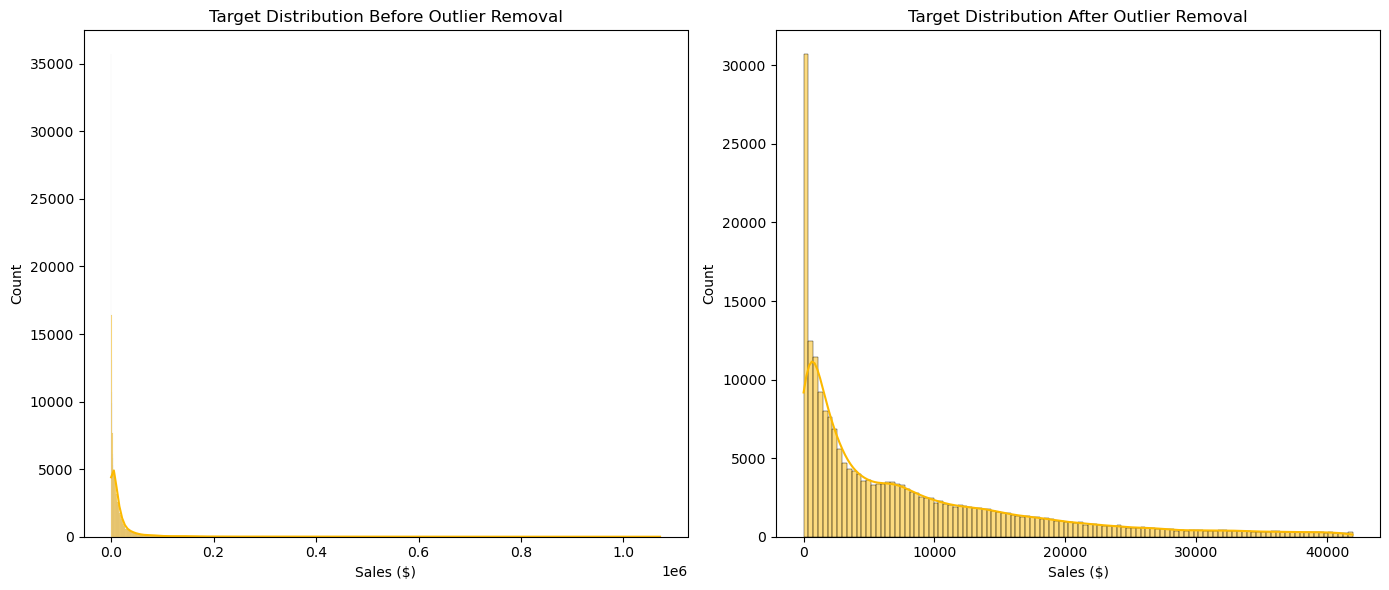

In [23]:
# Visualize target distribution before and after outlier removal
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(final_df[target], kde=True, color='#fcb900')
plt.title('Target Distribution Before Outlier Removal')
plt.xlabel('Sales ($)')

plt.subplot(1, 2, 2)
sns.histplot(model_df[target], kde=True, color='#fcb900')
plt.title('Target Distribution After Outlier Removal')
plt.xlabel('Sales ($)')

plt.tight_layout()
plt.show()


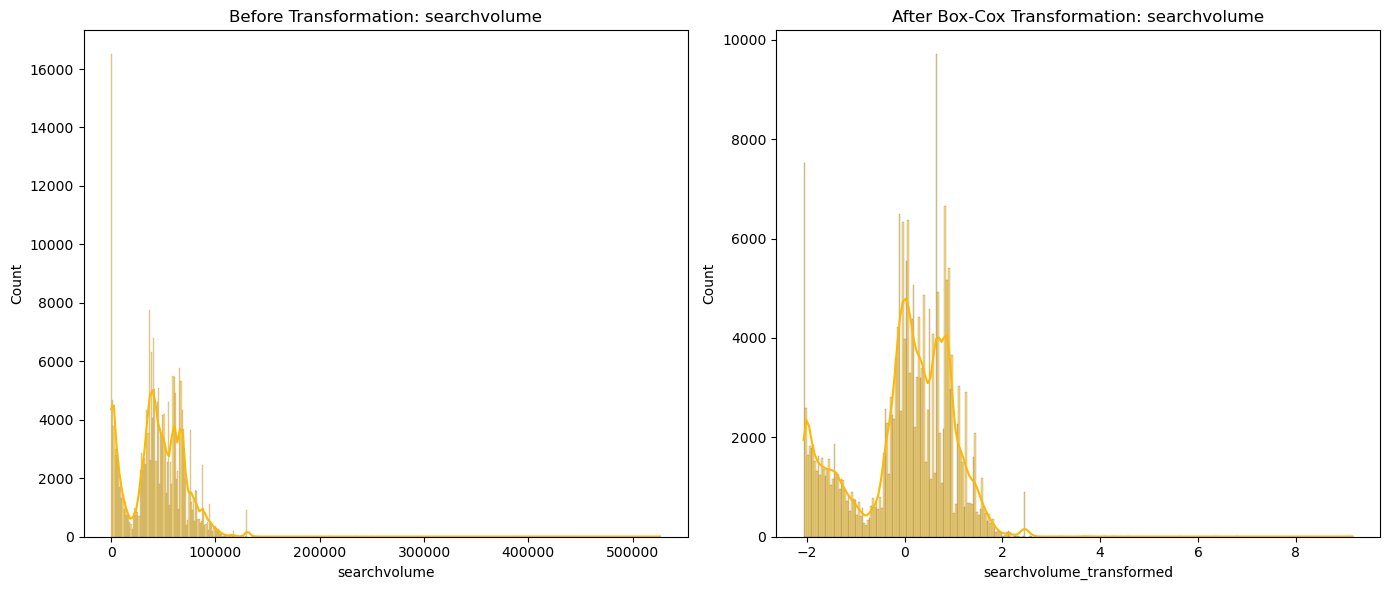

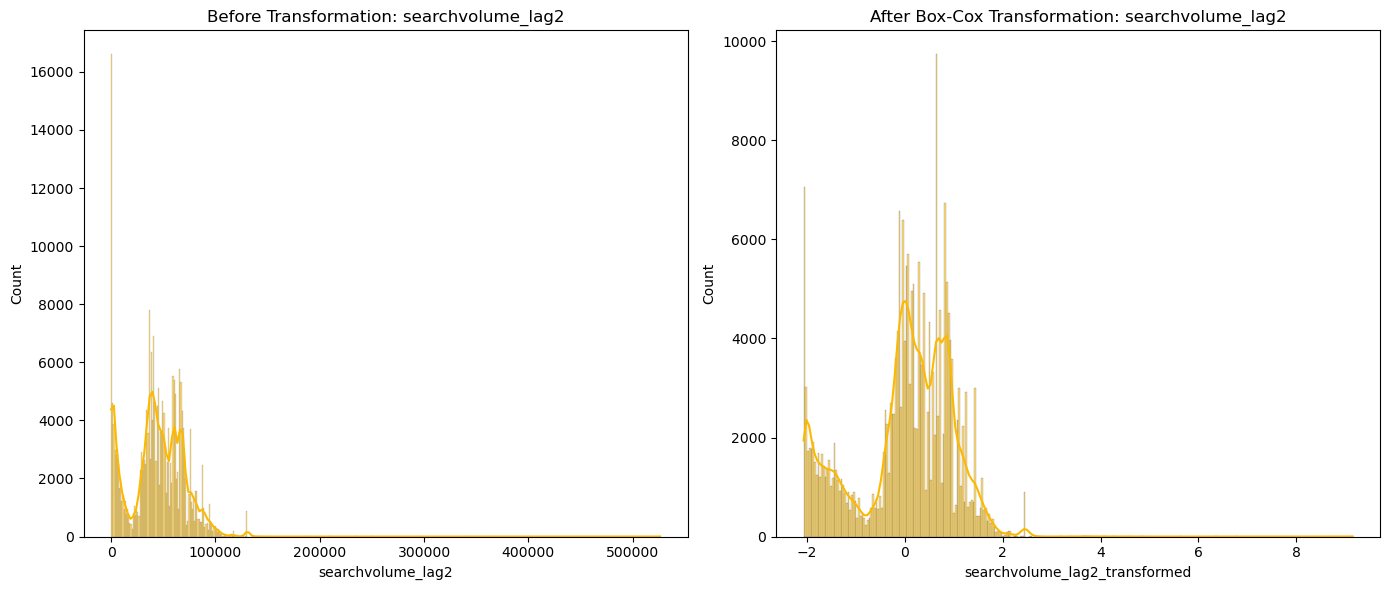

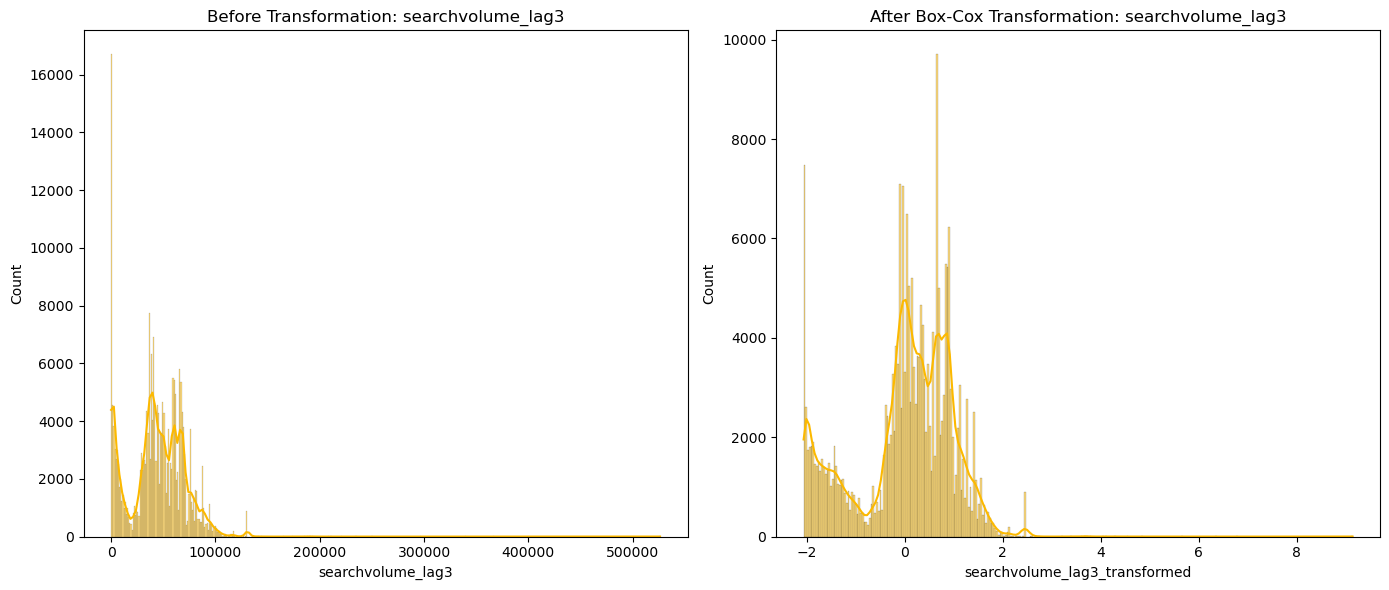

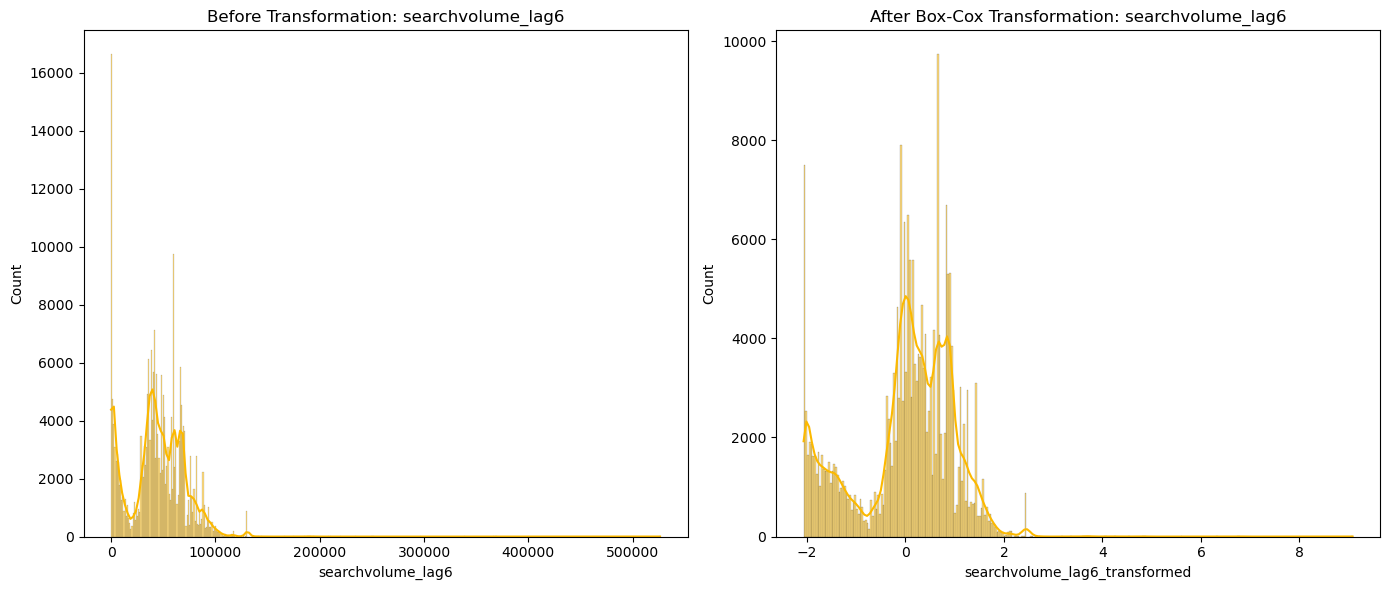

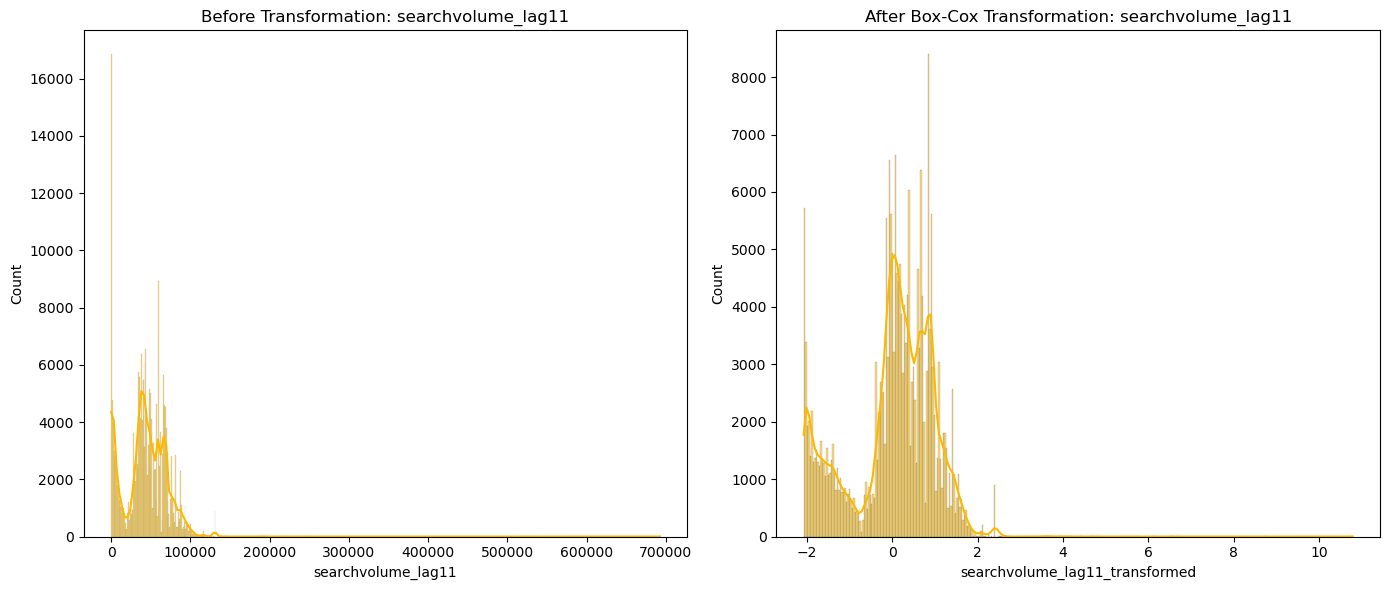

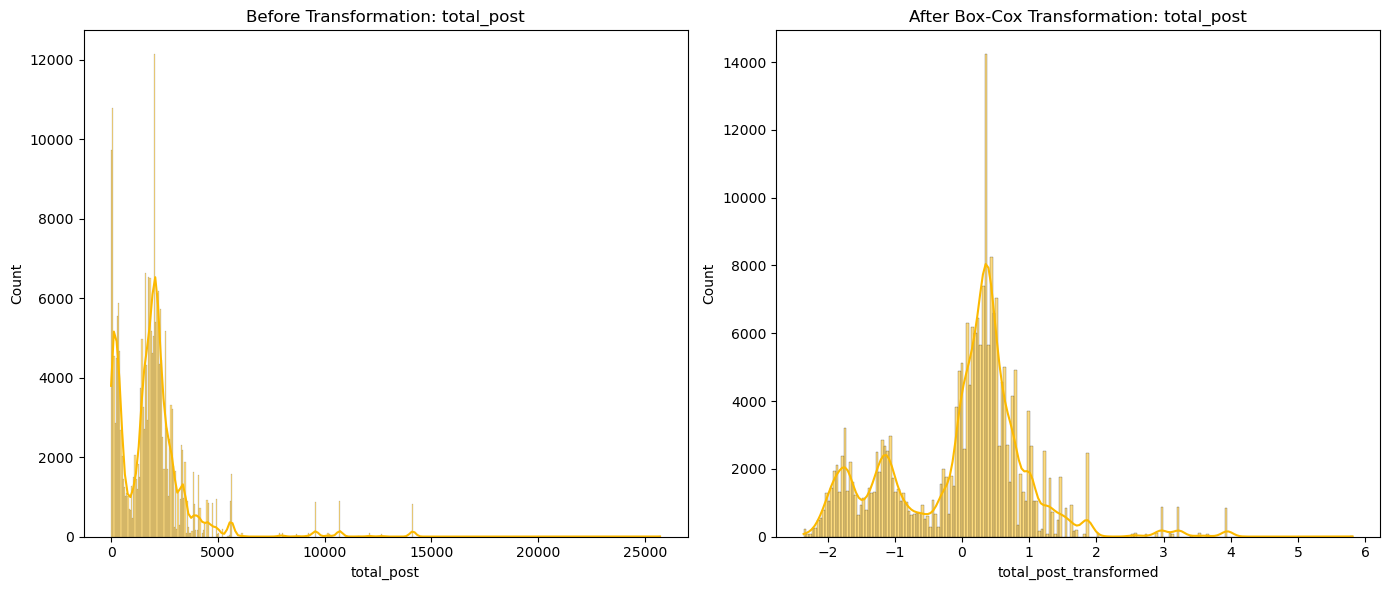

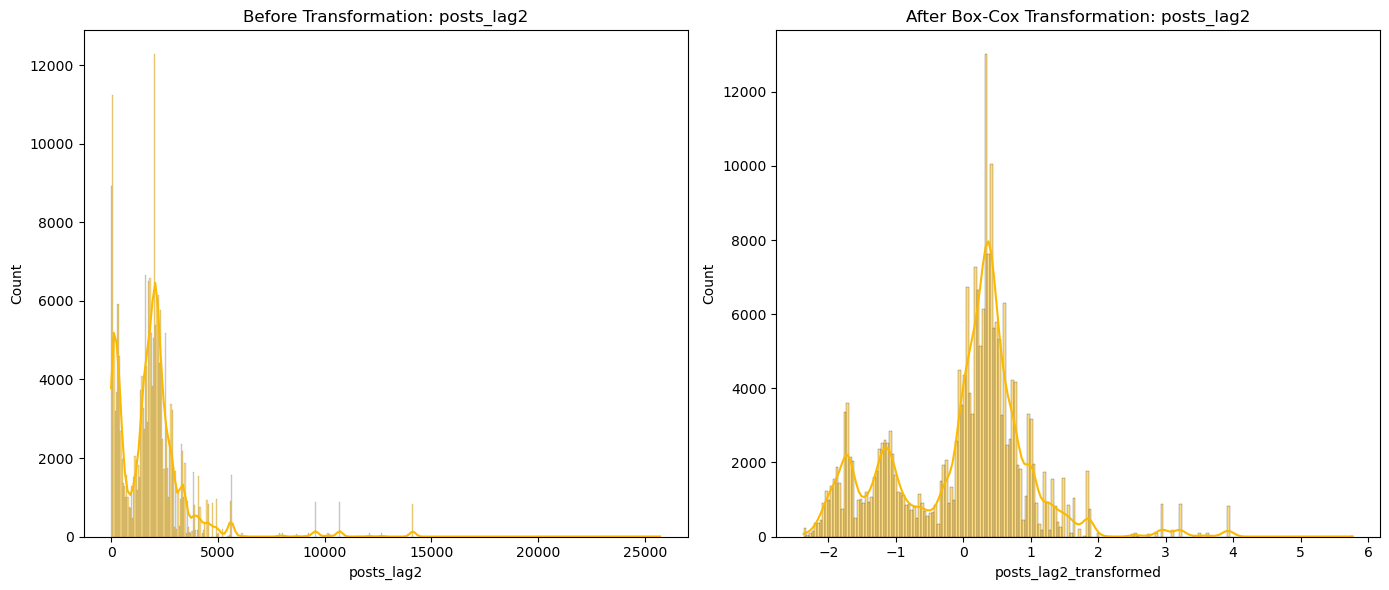

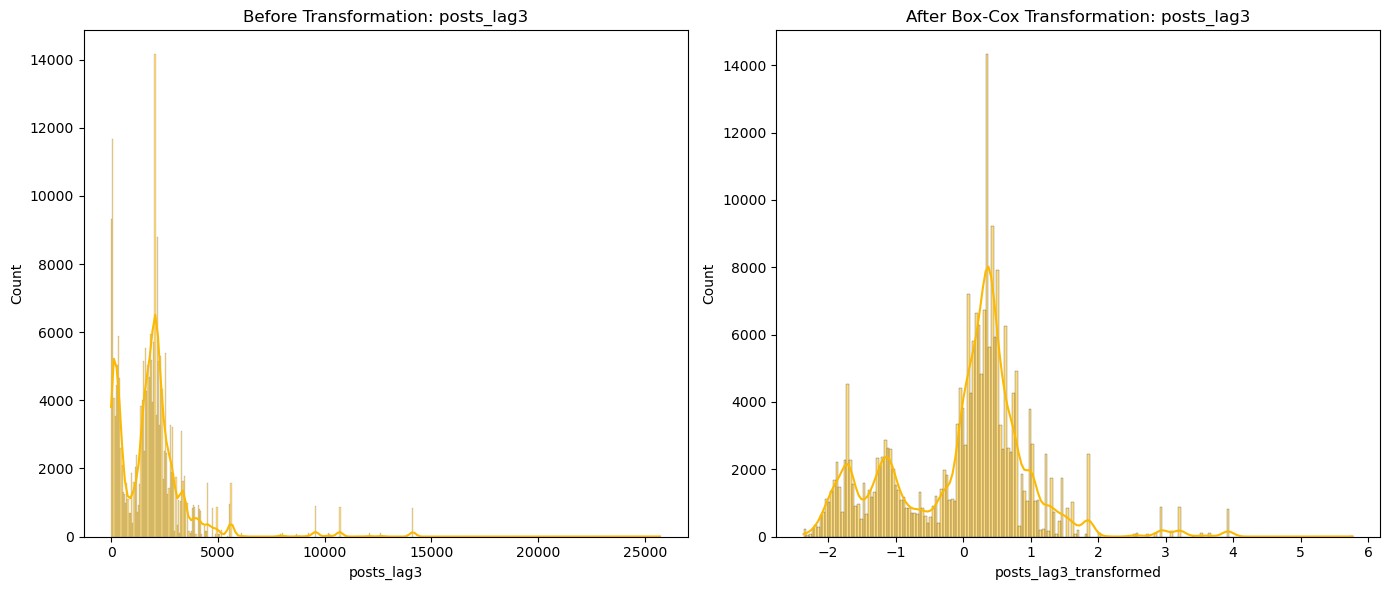

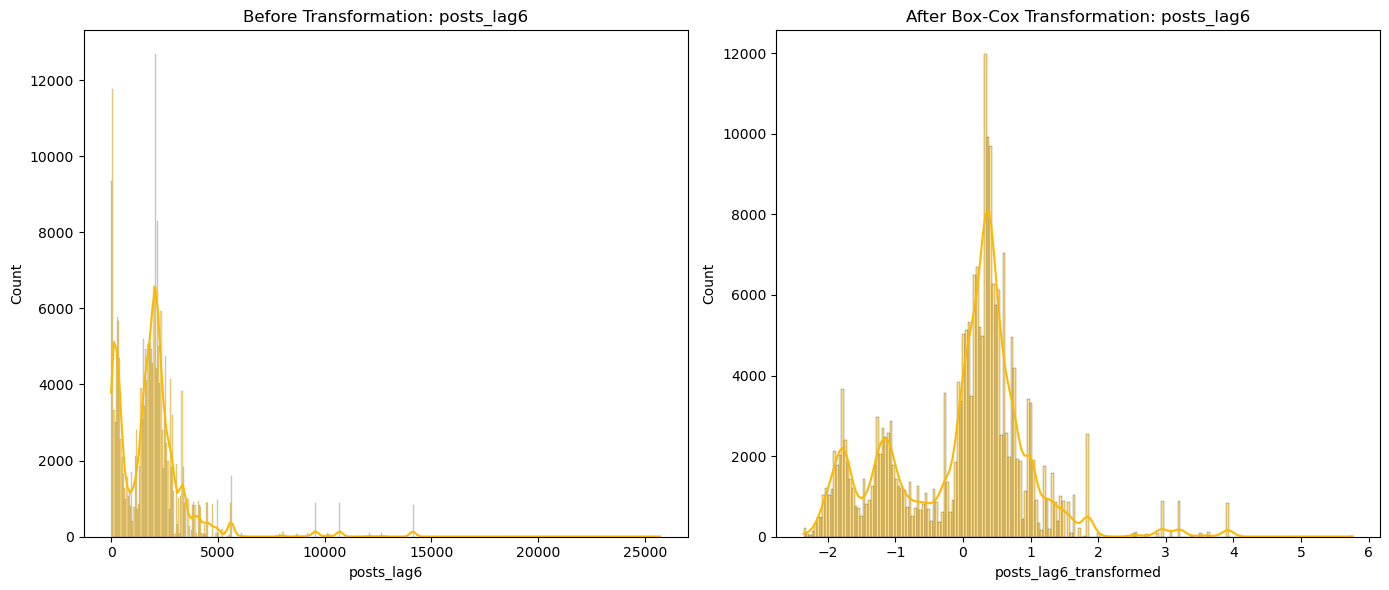

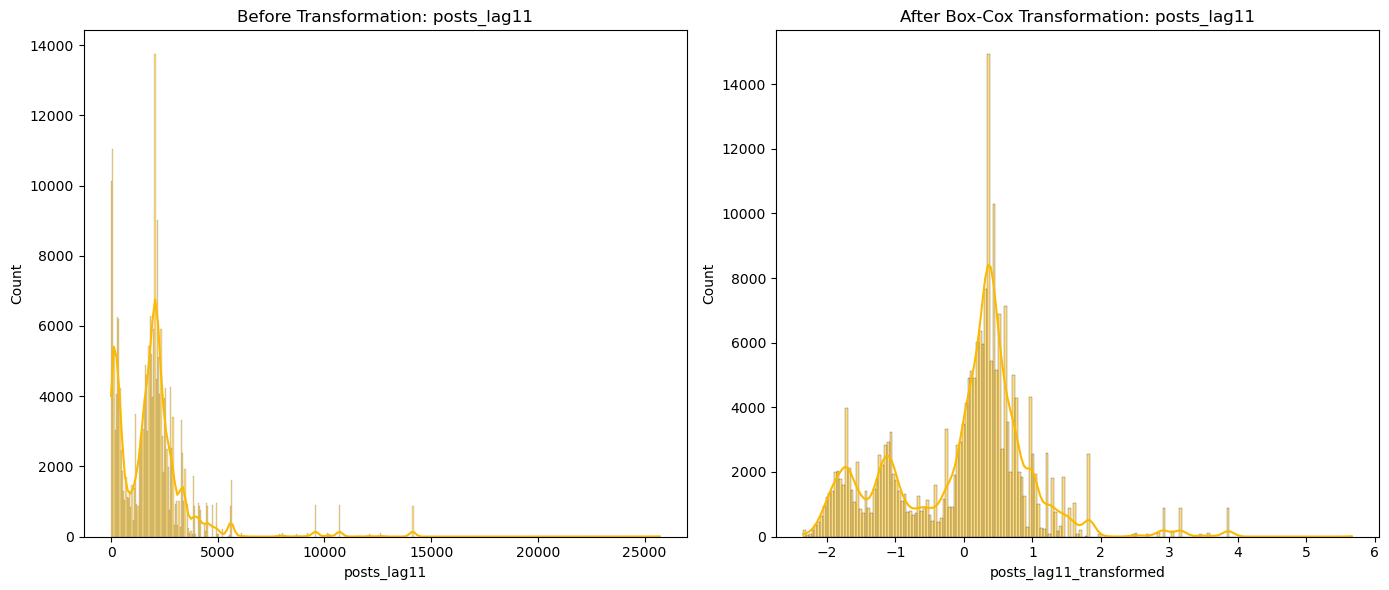

In [7]:
# Apply Box-Cox transformation to numeric features
transformed_features = {}

for feature in numeric_features:
    # Make sure all values are positive before applying Box-Cox
    model_df[feature] = model_df[feature] - model_df[feature].min() + 1  # Shift values to be positive
    
    # Apply Box-Cox transformation
    pt = PowerTransformer(method='box-cox')
    model_df[feature + '_transformed'] = pt.fit_transform(model_df[feature].values.reshape(-1, 1))
    
    # Store transformer for future use
    transformed_features[feature] = pt
    
    # Visualize transformation
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(model_df[feature], kde=True, color='#fcb900')
    plt.title(f'Before Transformation: {feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(model_df[feature + '_transformed'], kde=True, color='#fcb900')
    plt.title(f'After Box-Cox Transformation: {feature}')
    
    plt.tight_layout()
    plt.show()


In [8]:
# Update numeric features list to use transformed features
transformed_numeric_features = [f + '_transformed' for f in numeric_features]

# Train-test split
X = model_df[categorical_features + transformed_numeric_features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 181392 samples
Test set: 45349 samples


In [26]:
# Create Pool objects for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

In [27]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Use a simple model for grid search
simple_model = CatBoostRegressor(
    iterations=100,
    random_seed=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=simple_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, cat_features=categorical_features)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Best parameters: {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best cross-validation score: 0.6492


In [28]:
# Train final model with best parameters
best_params = grid_search.best_params_

final_model = CatBoostRegressor(
    iterations=500,
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    random_seed=42,
    verbose=50,
    custom_metric=['R2']
)

# Fit the model and use the eval_set to track performance on validation set
final_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=50,
    metric_period=10,
    early_stopping_rounds=50
)

# Save the model
model_path = op.join(model_output_dir, 'sales_prediction_model.cbm')
final_model.save_model(model_path)
print(f"Model saved to {model_path}")


0:	learn: 8862.0840759	test: 8841.8812899	best: 8841.8812899 (0)	total: 171ms	remaining: 1m 25s
50:	learn: 5186.8532100	test: 4904.6265411	best: 4904.6265411 (50)	total: 2.74s	remaining: 24.1s
100:	learn: 4910.5940996	test: 4630.0184841	best: 4630.0184841 (100)	total: 5.88s	remaining: 23.2s
150:	learn: 4742.6006747	test: 4463.8516279	best: 4463.8516279 (150)	total: 9.72s	remaining: 22.5s
200:	learn: 4597.9003920	test: 4331.6217651	best: 4331.6217651 (200)	total: 14.1s	remaining: 21s
250:	learn: 4455.2127575	test: 4201.6143518	best: 4201.6143518 (250)	total: 18.1s	remaining: 17.9s
300:	learn: 4339.4855194	test: 4098.3927795	best: 4098.3927795 (300)	total: 21.7s	remaining: 14.4s
350:	learn: 4247.9972344	test: 4013.4535584	best: 4013.4535584 (350)	total: 25.7s	remaining: 10.9s
400:	learn: 4181.3832034	test: 3954.7275857	best: 3954.7275857 (400)	total: 30.2s	remaining: 7.46s
450:	learn: 4113.1859852	test: 3893.8518485	best: 3893.8518485 (450)	total: 35.3s	remaining: 3.83s
499:	learn: 4054.

In [29]:
# Predictions
y_pred = final_model.predict(X_test)


In [33]:
# Filter out zeros in y_test before computing MAPE
non_zero_mask = y_test != 0
y_test_filtered = y_test[non_zero_mask]
y_pred_filtered = y_pred[non_zero_mask]
X_test_filtered = X_test[non_zero_mask]


In [34]:
# Evaluate metrics
r2 = r2_score(y_test_filtered, y_pred_filtered)
mape = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)
rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))

# Adjusted R2
n = X_test_filtered.shape[0]  
p = X_test_filtered.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [35]:
print("\n===== Model Evaluation =====")
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R Squared: {adjusted_r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")



===== Model Evaluation =====
R-squared: 0.8298
Adjusted R Squared: 0.8297
MAPE: 7.3099
RMSE: 3854.6679


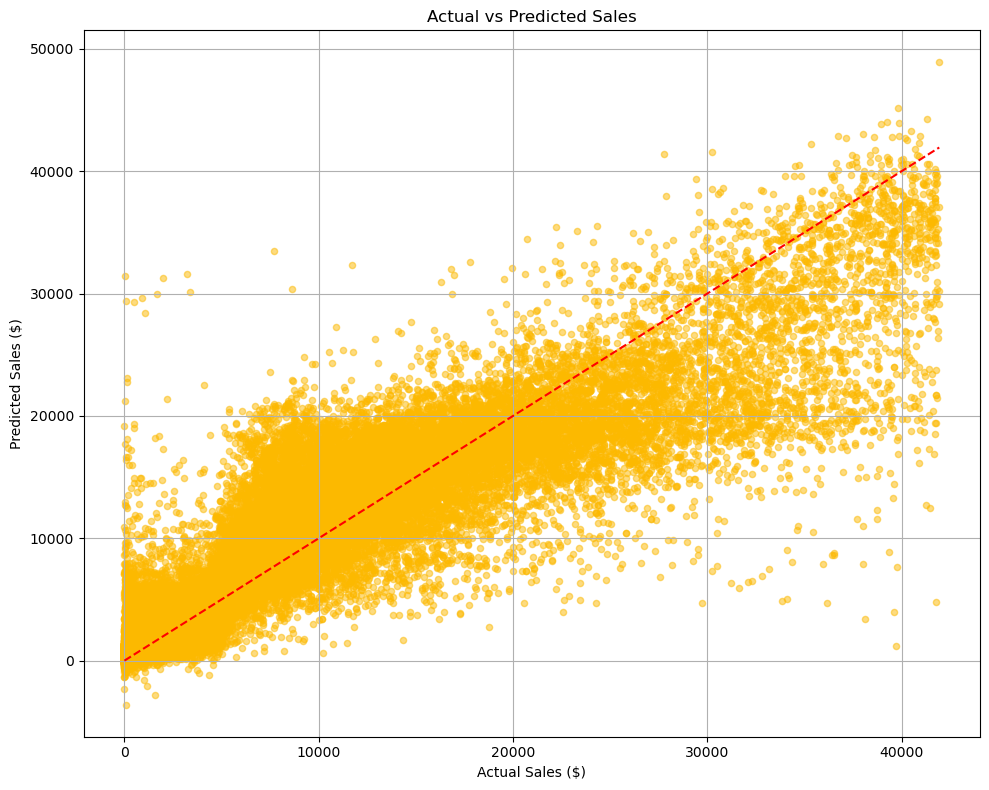

In [37]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test_filtered, y_pred_filtered,color='#fcb900', alpha=0.5, s=20)
plt.xlabel("Actual Sales ($)")
plt.ylabel("Predicted Sales ($)")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 
         color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'actual_vs_predicted.png'), dpi=300)
plt.show()

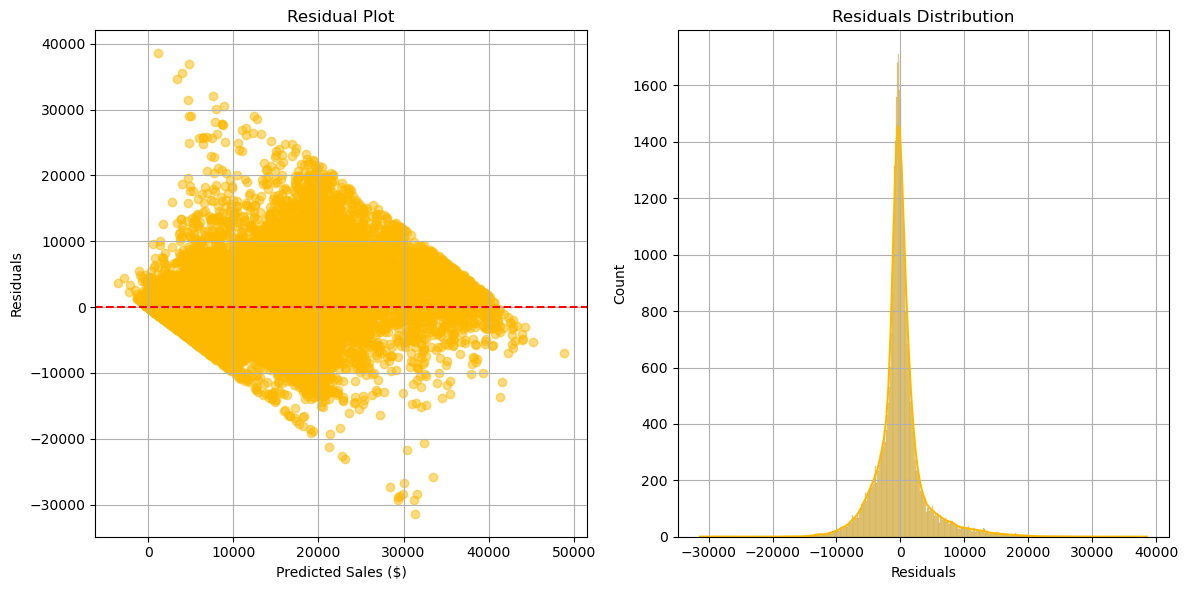

In [39]:
# Step 13: Plot residuals
residuals = y_test_filtered - y_pred_filtered
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_filtered, residuals, color='#fcb900', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales ($)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='#fcb900')
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.grid(True)

plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'residual_analysis.png'), dpi=300)
plt.show()

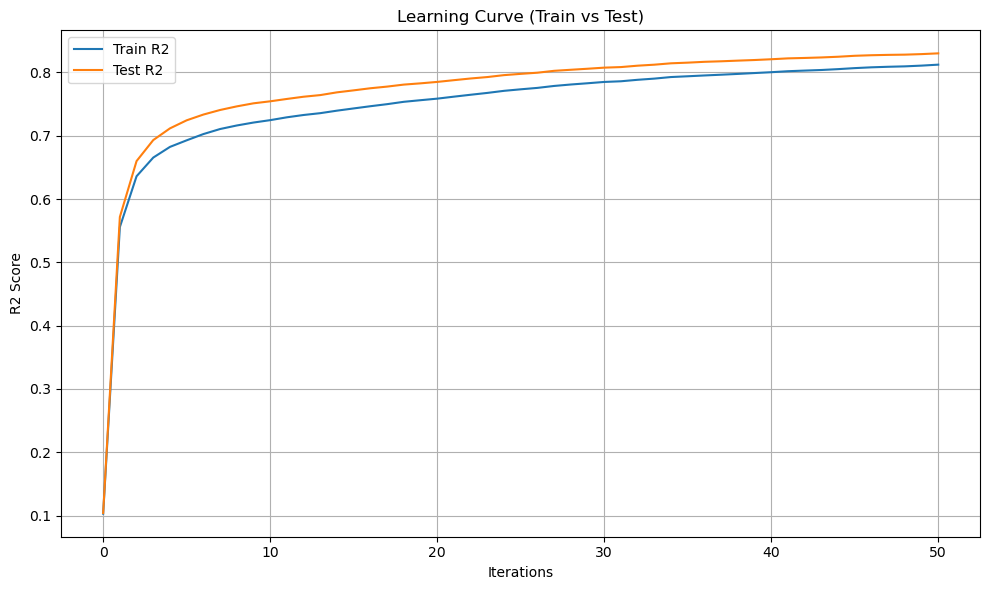

In [40]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(final_model.get_evals_result()['learn']['R2'], label='Train R2')
plt.plot(final_model.get_evals_result()['validation']['R2'], label='Test R2')
plt.xlabel("Iterations")
plt.ylabel("R2 Score")
plt.title("Learning Curve (Train vs Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'learning_curve.png'), dpi=300)
plt.show()

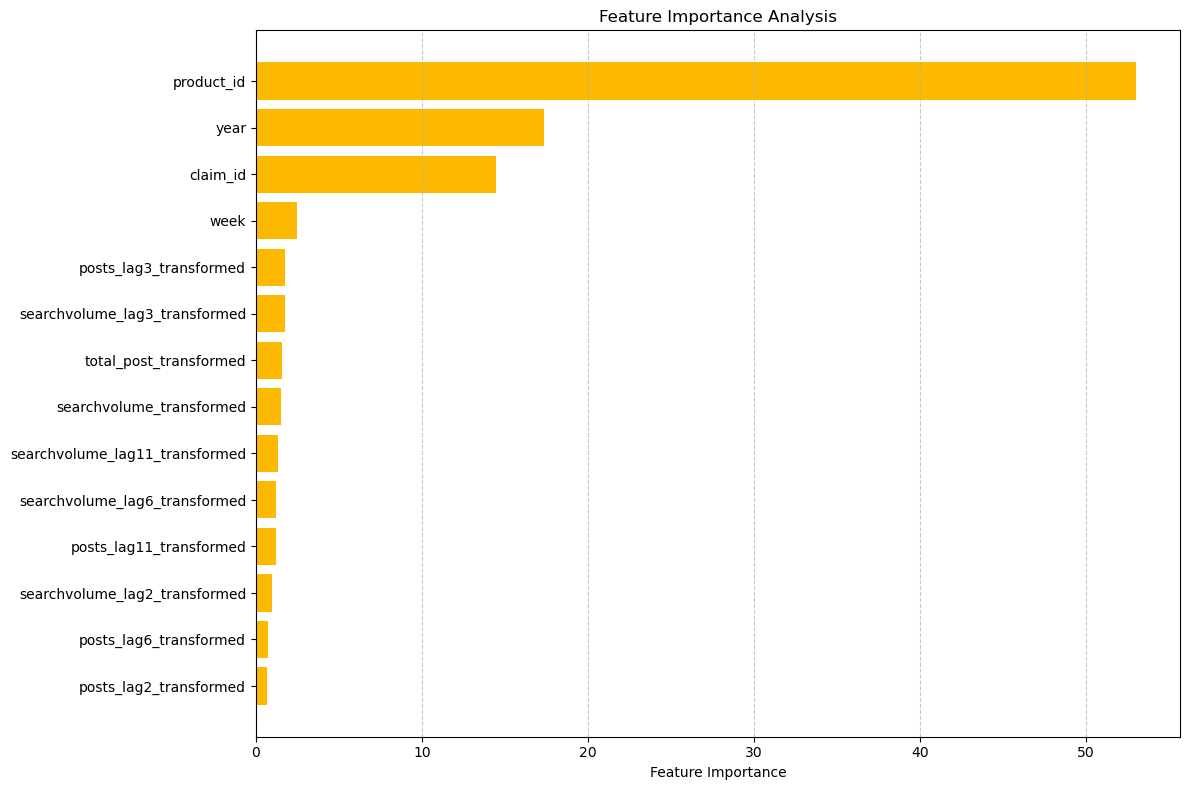

In [42]:
# Feature importance analysis
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#fcb900')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Optional if you want XGBoost and LightGBM
from xgboost import XGBRegressor


Model saved to models/linear_regression_model.pkl

===== Model Evaluation =====
R-squared: 0.0615
Adjusted R Squared: 0.0612
MAPE: 71.1298
RMSE: 9051.3177


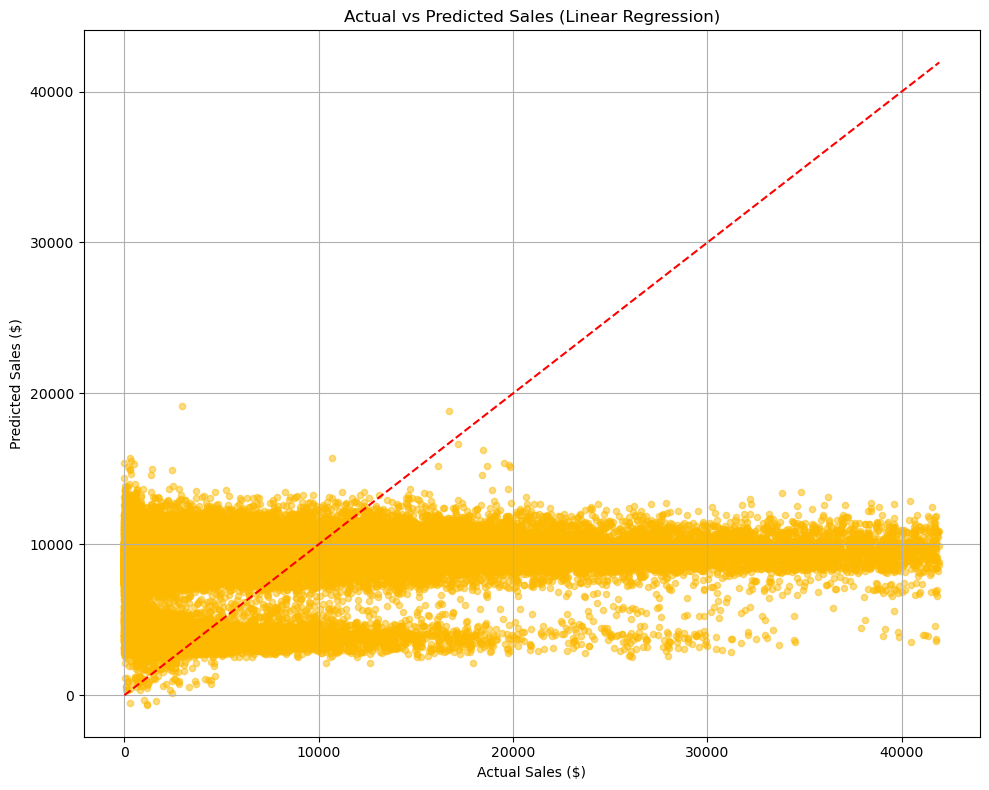

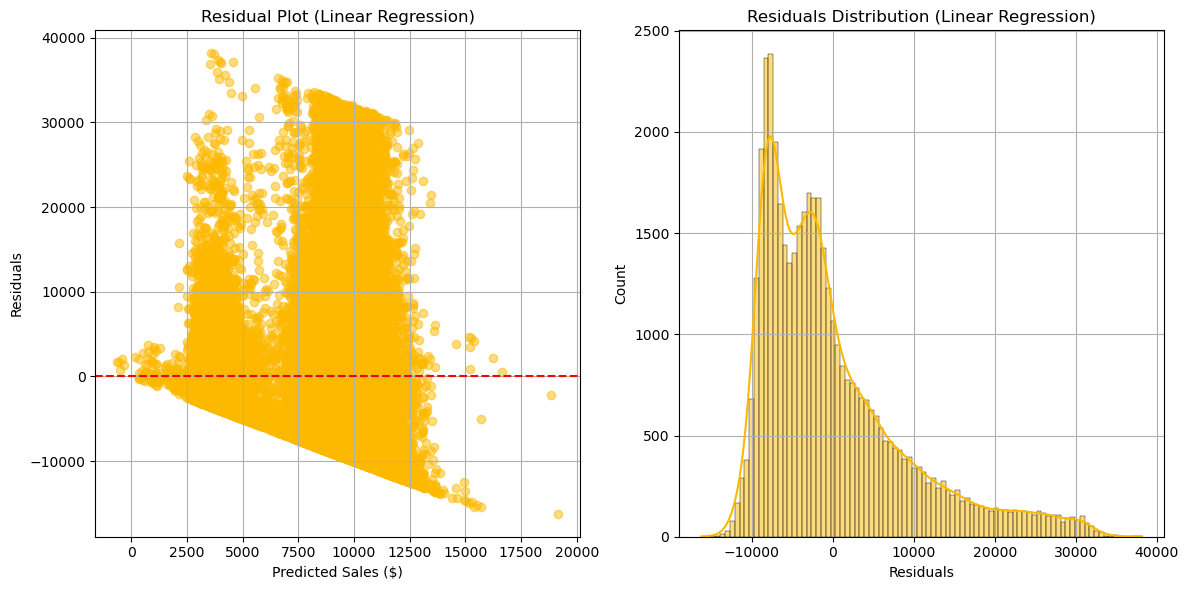

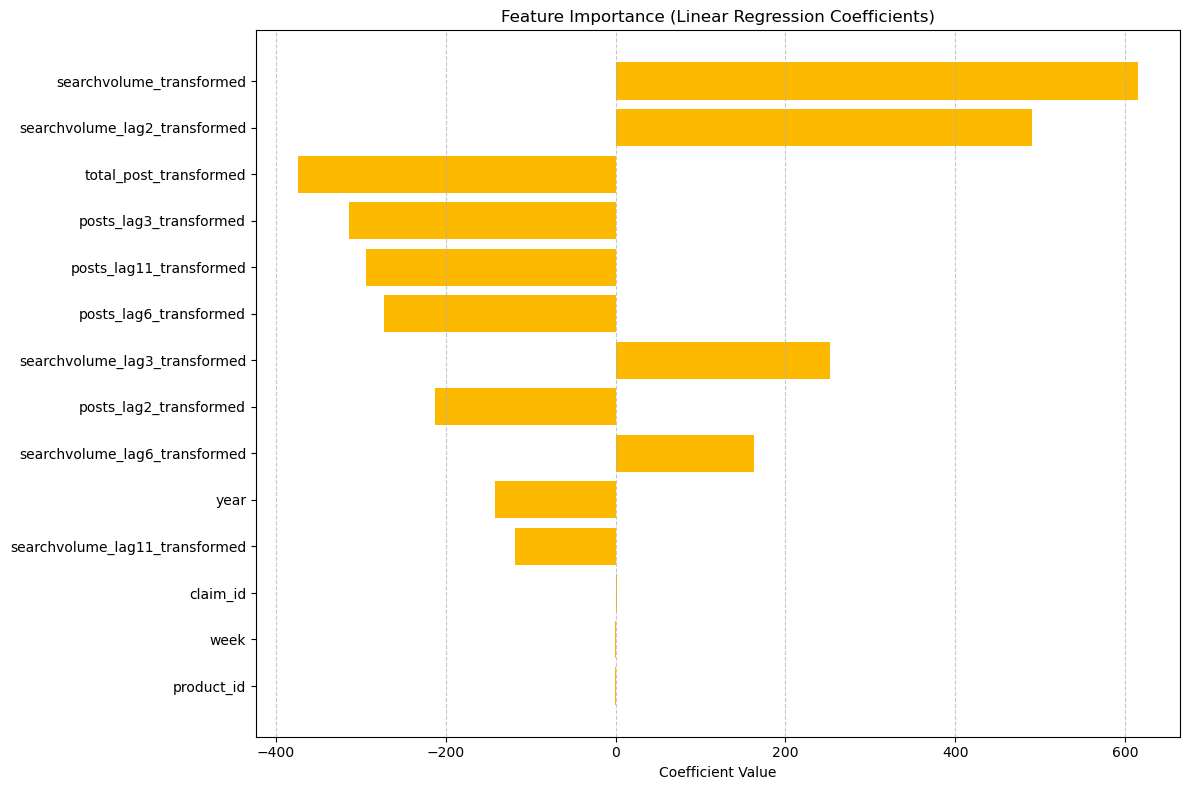

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os.path as op

# Assume model_output_dir is already defined

# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
linear_model = LinearRegression()

# No hyperparameters to tune for basic Linear Regression — just fit
linear_model.fit(X_train, y_train)

# Save model manually if needed
# You can use joblib or pickle (not CatBoost's save_model)
import joblib
model_path = op.join(model_output_dir, 'linear_regression_model.pkl')
joblib.dump(linear_model, model_path)
print(f"Model saved to {model_path}")

# Predictions
y_pred = linear_model.predict(X_test)

# Filter out zeros in y_test before computing MAPE
non_zero_mask = y_test != 0
y_test_filtered = y_test[non_zero_mask]
y_pred_filtered = y_pred[non_zero_mask]
X_test_filtered = X_test[non_zero_mask]

# Evaluate metrics
r2 = r2_score(y_test_filtered, y_pred_filtered)
mape = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)
rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))

# Adjusted R2
n = X_test_filtered.shape[0]  
p = X_test_filtered.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n===== Model Evaluation =====")
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R Squared: {adjusted_r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test_filtered, y_pred_filtered, color='#fcb900', alpha=0.5, s=20)
plt.xlabel("Actual Sales ($)")
plt.ylabel("Predicted Sales ($)")
plt.title("Actual vs Predicted Sales (Linear Regression)")
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()],
         color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'actual_vs_predicted_linear.png'), dpi=300)
plt.show()

# Residuals
residuals = y_test_filtered - y_pred_filtered

# Residual plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_filtered, residuals, color='#fcb900', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales ($)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Linear Regression)")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='#fcb900')
plt.xlabel("Residuals")
plt.title("Residuals Distribution (Linear Regression)")
plt.grid(True)

plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'residual_analysis_linear.png'), dpi=300)
plt.show()

# Feature Importance for Linear Regression (coefficients)
coef = linear_model.coef_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coef
})
importance_df['Abs_Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values('Abs_Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#fcb900')
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'feature_importance_linear.png'), dpi=300)
plt.show()


In [9]:
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# Assuming you already have these:
# X, y, model_output_dir

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Grid search
param_grid = {
    "fit_intercept": [True, False],
    "normalize": [True, False]   # Note: in sklearn >=0.24, normalize param is deprecated
}

In [13]:
grid_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

f

Best parameters: {'fit_intercept': True, 'normalize': False}
Best cross-validation score: 0.0620


In [14]:
# Final model
best_model = LinearRegression(**grid_search.best_params_)
best_model.fit(X_train, y_train)

LinearRegression(normalize=False)

In [15]:
def evaluate_and_plot(model, model_name):
    y_pred = model.predict(X_test)
    non_zero_mask = y_test != 0
    y_test_filtered = y_test[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]
    X_test_filtered = X_test[non_zero_mask]

    r2 = r2_score(y_test_filtered, y_pred_filtered)
    mape = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)
    rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
    n = X_test_filtered.shape[0]
    p = X_test_filtered.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"\n===== {model_name} Model Evaluation =====")
    print(f"R-squared: {r2:.4f}")
    print(f"Adjusted R Squared: {adjusted_r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Actual vs Predicted
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5, color='#fcb900')
    plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()],
             color='red', linestyle='--')
    plt.xlabel('Actual Sales ($)')
    plt.ylabel('Predicted Sales ($)')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(op.join(model_output_dir, f'{model_name}_actual_vs_predicted.png'), dpi=300)
    plt.show()

    # Residuals plot
    residuals = y_test_filtered - y_pred_filtered
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_filtered, residuals, color='#fcb900')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Sales ($)')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='#fcb900')
    plt.xlabel('Residuals')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(op.join(model_output_dir, f'{model_name}_residual_analysis.png'), dpi=300)
    plt.show()


===== LinearRegression Model Evaluation =====
R-squared: 0.0615
Adjusted R Squared: 0.0612
MAPE: 71.1298
RMSE: 9051.3177


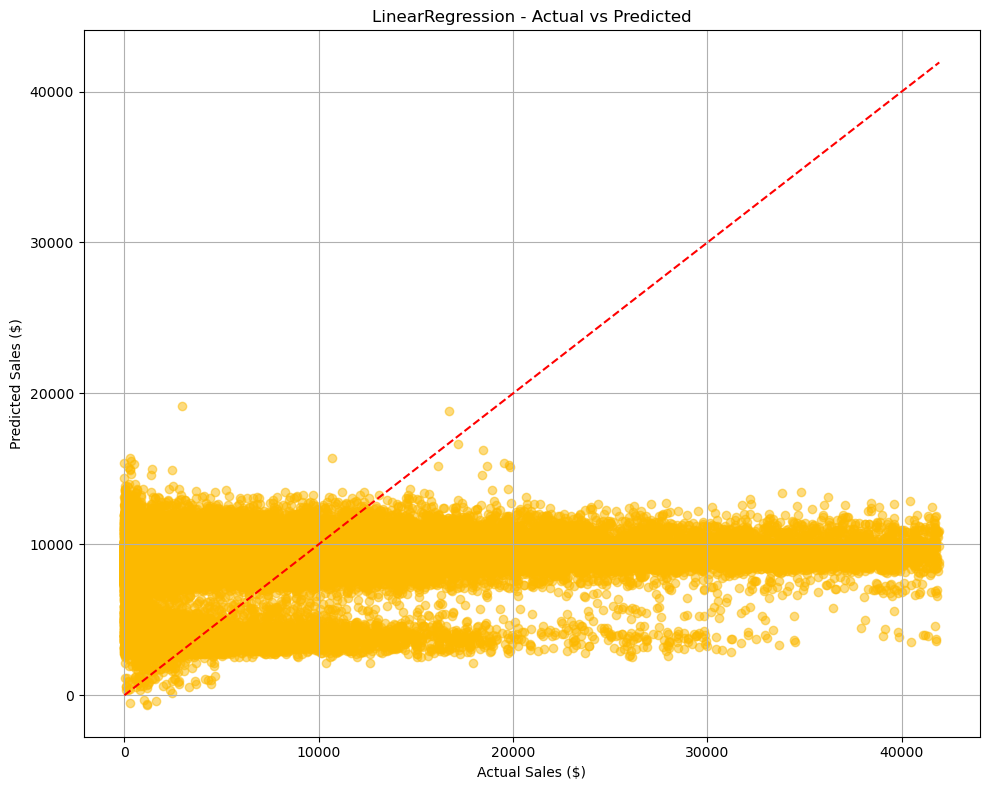

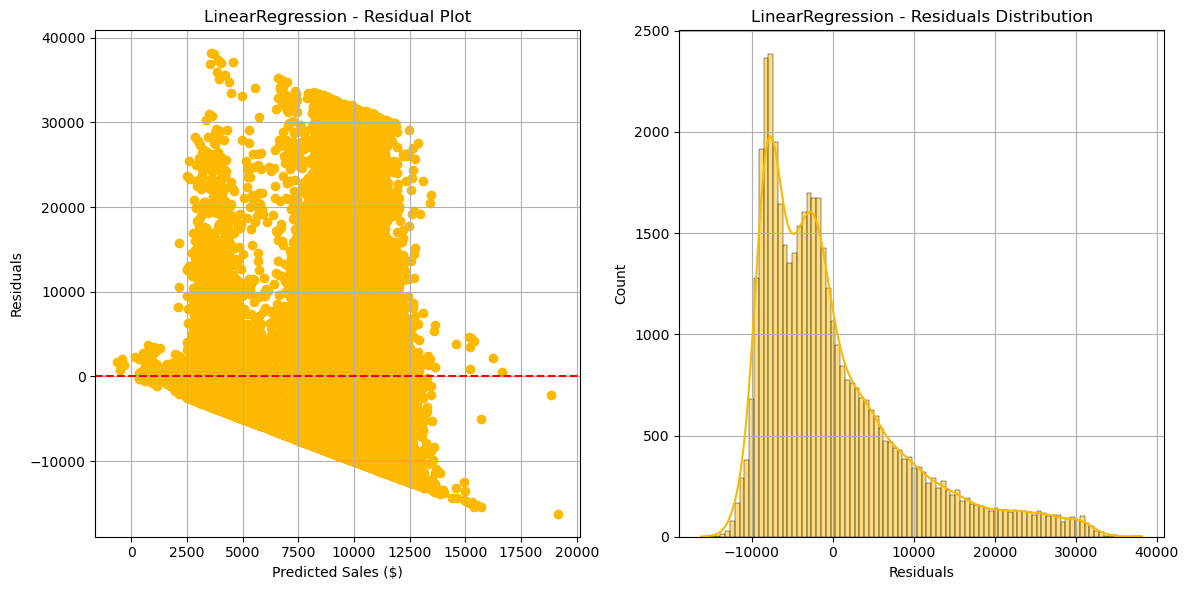

In [16]:
evaluate_and_plot(best_model, 'LinearRegression')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pool objects for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Define RandomForest model and param distribution
param_grid  = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='r2',  # We want to optimize for R^2
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all CPU cores to parallelize the search
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and cross-validation score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the final model with the best parameters
best_rf_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

Random Forest model saved to models/random_forest_model.pkl

===== RandomForestRegressor Model Evaluation =====
R-squared: 0.6475
Adjusted R Squared: 0.6474
MAPE: 35.7220
RMSE: 5547.3315


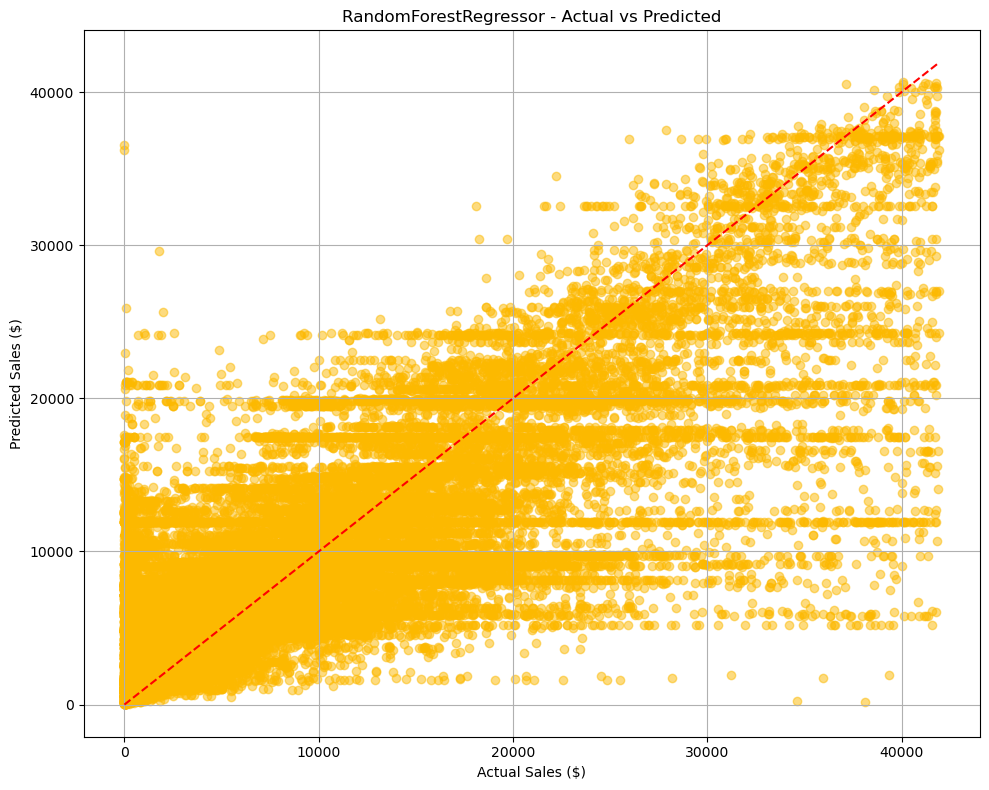

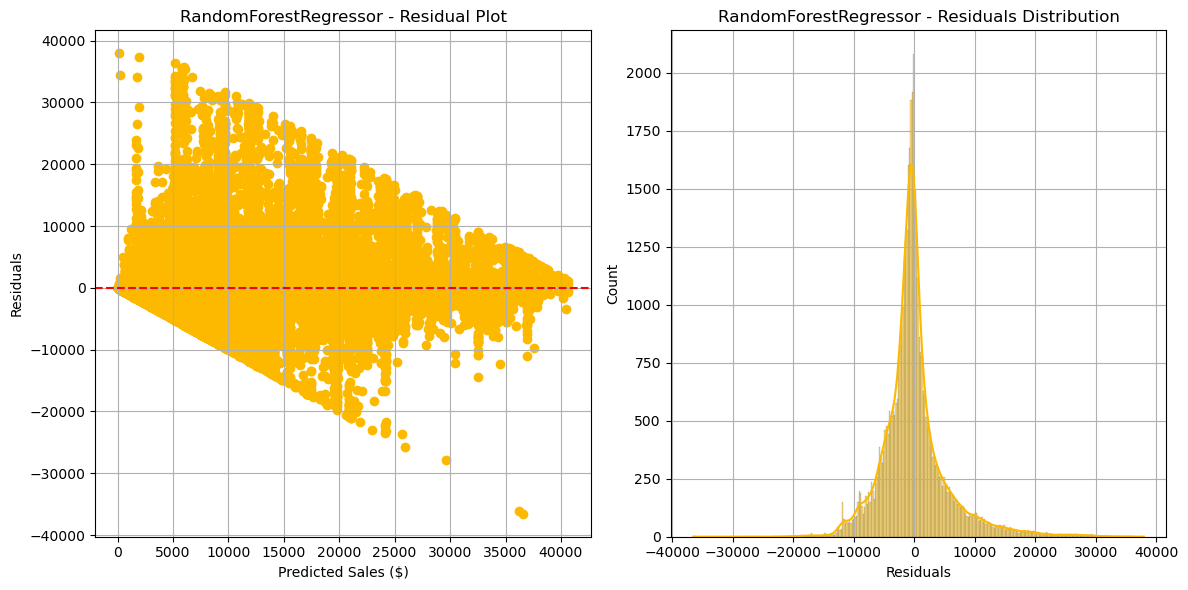

In [27]:
# Save the trained model
model_save_path = op.join(model_output_dir, 'random_forest_model.pkl')
joblib.dump(best_rf_model, model_save_path)
print(f"Random Forest model saved to {model_save_path}")

# Evaluate and plot the model
evaluate_and_plot(best_rf_model,"RandomForestRegressor")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best cross-validation score: 0.8347
Model saved to models/GradientBoostingRegressor_model.pkl

===== GradientBoostingRegressor Model Evaluation =====
R-squared: 0.8361
Adjusted R Squared: 0.8360
MAPE: 24.6895
RMSE: 3782.7785


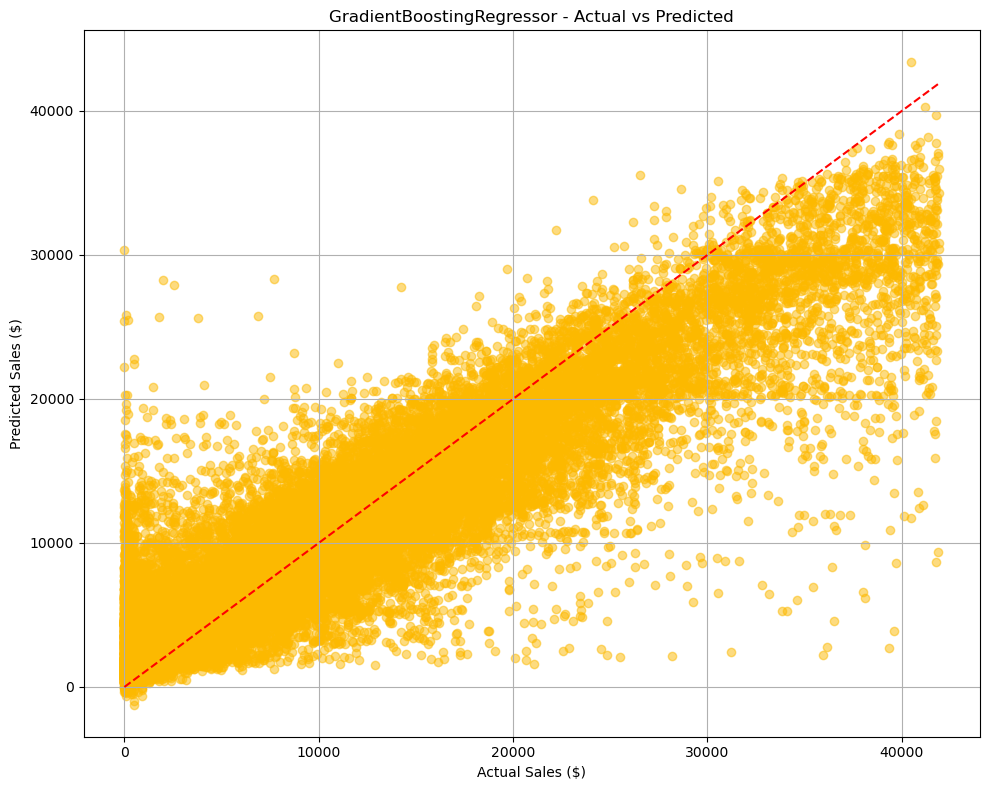

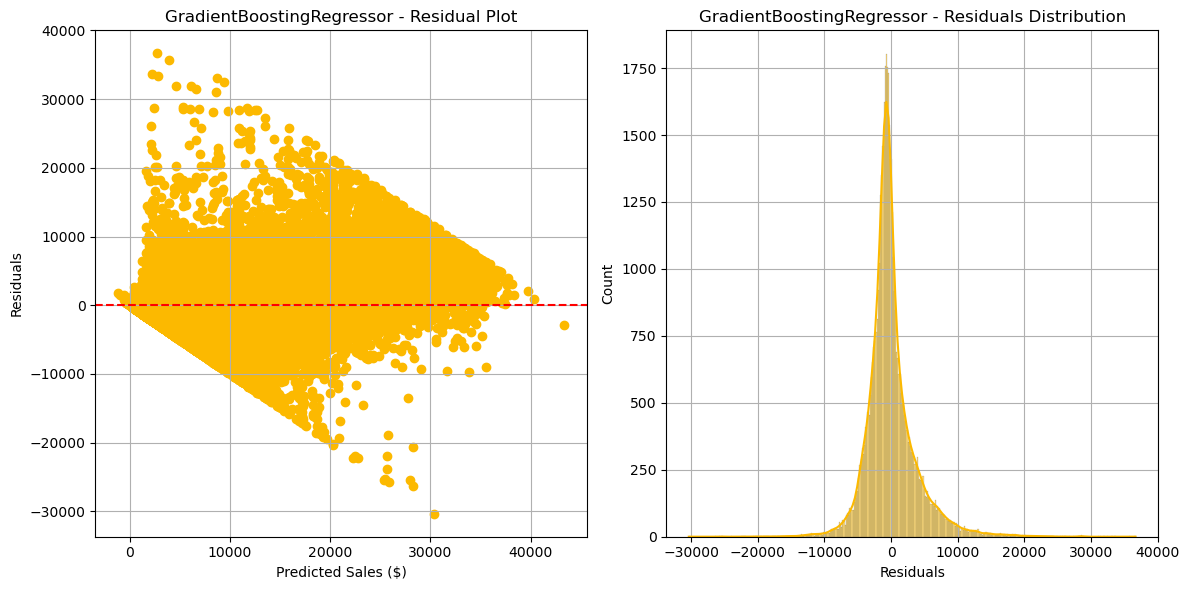

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_model = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

model_save_path = op.join(model_output_dir, 'GradientBoostingRegressor_model.pkl')
joblib.dump(best_model, model_save_path)
print(f"Model saved to {model_save_path}")

evaluate_and_plot(best_model, 'GradientBoostingRegressor')


In [30]:
# Train-test split
X_new = model_df[transformed_numeric_features]
y_new = model_df[target]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/alisaz/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/dat

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.0466
Model saved to models/XGBRegressor_model.pkl

===== XGBRegressor Model Evaluation =====
R-squared: 0.0473
Adjusted R Squared: 0.0471
MAPE: 67.4783
RMSE: 9119.5152


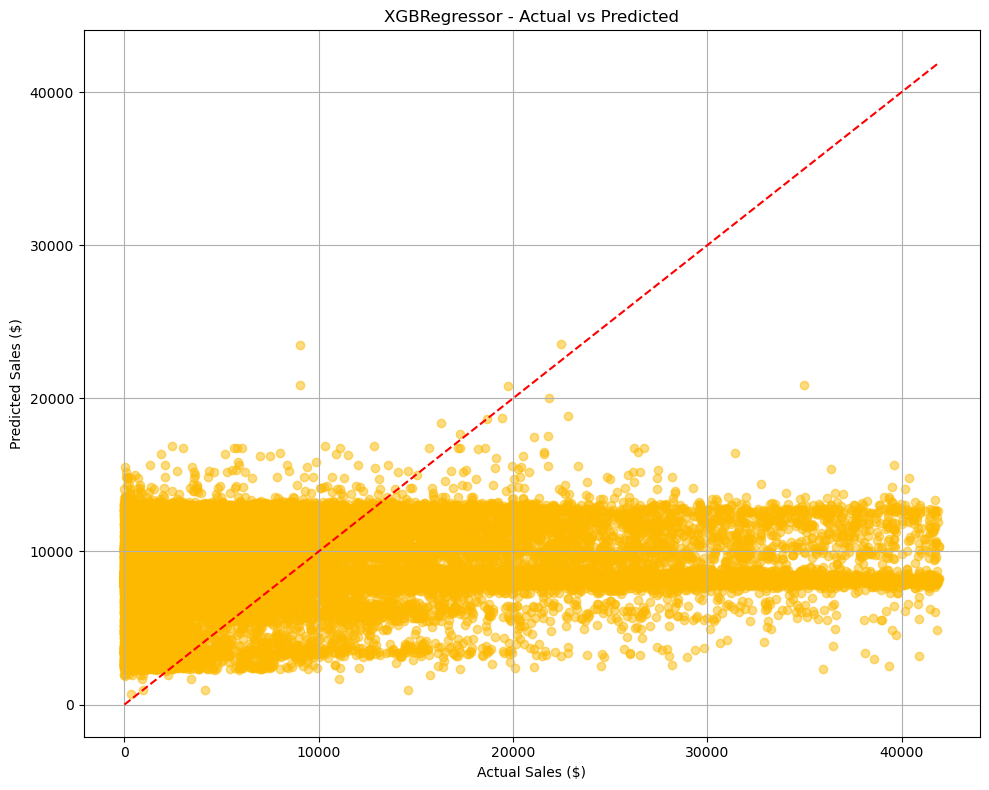

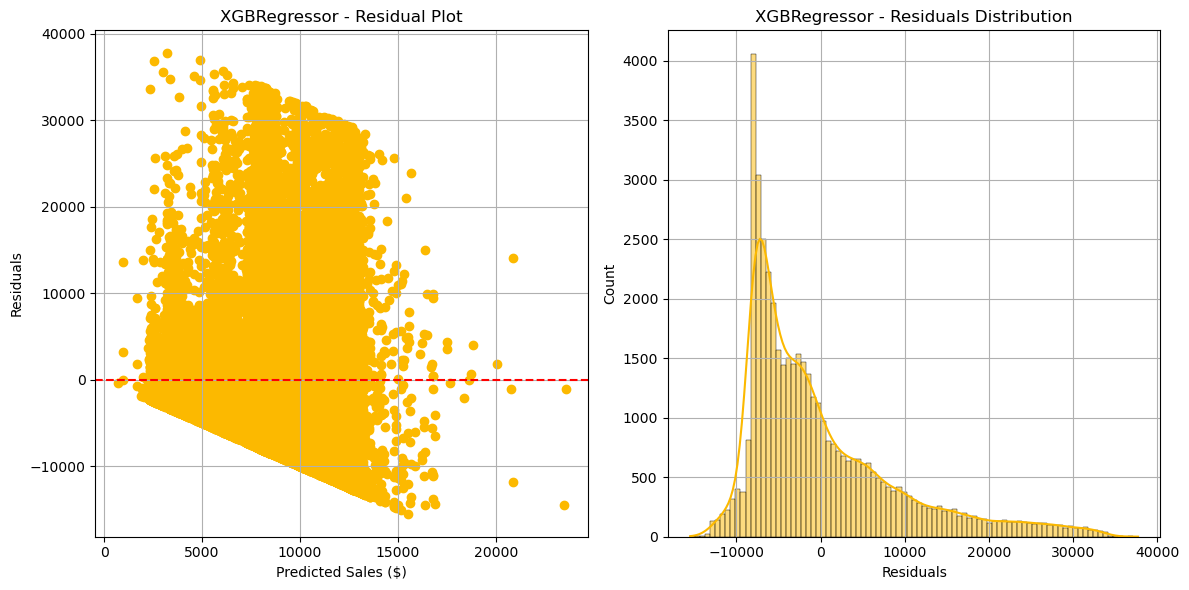

In [31]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_model = XGBRegressor(**grid_search.best_params_, random_state=42, verbosity=0)
best_model.fit(X_train, y_train)

model_save_path = op.join(model_output_dir, 'XGBRegressor_model.pkl')
joblib.dump(best_model, model_save_path)
print(f"Model saved to {model_save_path}")

evaluate_and_plot(best_model, 'XGBRegressor')
